In [17]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import multiprocessing

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanAbsoluteError,MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
from tensorflow.keras import layers, models, Input
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define train and test set

In [2]:
with open('dataset.json', 'r') as f:
    dataset = json.load(f)

# Split the list of dicts in train and test already.
train, test = train_test_split(dataset, test_size=0.2, random_state=11)

# Preprocessing

In [3]:
# Create a function that extracts the appid - price - screenshot from the list of dicts

def parse_json_mids(l):
    dfl = []
    for gamedata in l:
        _id = gamedata['appid']
        _price = int(gamedata['price'])
        _title = gamedata['title']
        _img = gamedata['screenshots']
        for screenshot in _img:
            dfl.append(
                [_id, _title, _price, screenshot]
            )
    df = pd.DataFrame(dfl)
    df.columns = ['appid', 'title', 'price', 'screenshot']
    return(df)

traindf = parse_json_mids(train)
testdf = parse_json_mids(test)

<Axes: xlabel='price', ylabel='Density'>

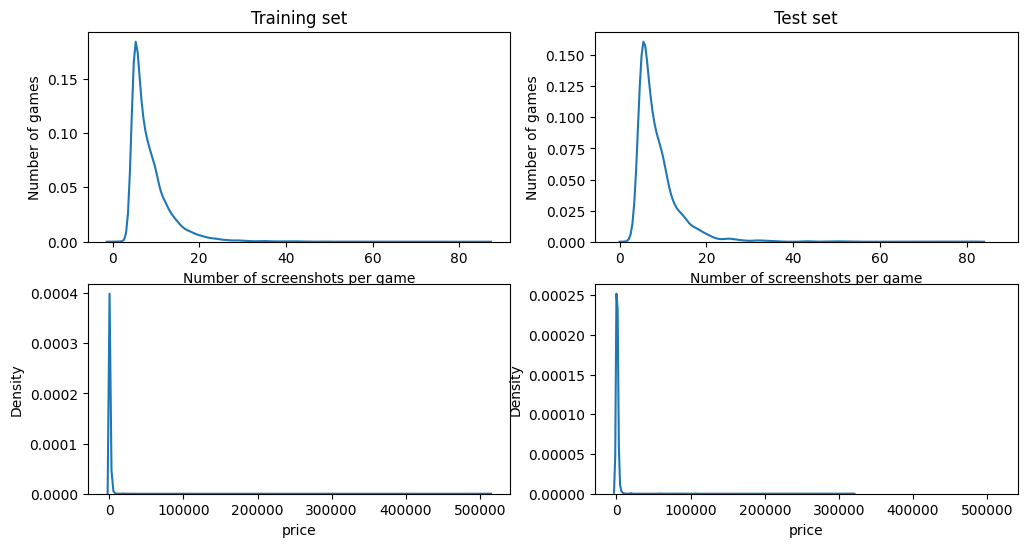

In [4]:
# Check number of screenshots per game
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6), sharex='row')
sns.kdeplot(traindf['appid'].value_counts(), ax = ax[0,0])
ax[0,0].set_xlabel("Number of screenshots per game")
ax[0,0].set_ylabel("Number of games")
ax[0,0].set_title("Training set")

sns.kdeplot(testdf['appid'].value_counts(), ax = ax[0,1])
ax[0,1].set_xlabel("Number of screenshots per game")
ax[0,1].set_ylabel("Number of games")
ax[0,1].set_title("Test set")

sns.kdeplot(traindf['price'], ax = ax[1,0])
sns.kdeplot(testdf['price'], ax = ax[1,1])

In [5]:
# Remove all the games with prices > 10000
traindf = traindf[traindf['price'] <= 10000]
testdf = testdf[testdf['price'] <= 10000]

## Process images

In [6]:
def resize_img(_):
    IMPATH, TARGET = _
    if os.path.exists(os.path.join(TARGET, IMPATH)):
        return
    try:
        _img = Image.open(os.path.join('images', IMPATH))
    except:
        return IMPATH
    _imgresized = _img.resize((224, 224))
    _imgresized.save(os.path.join(TARGET, IMPATH), quality=50)

if not os.path.exists('images_resized'):
    os.mkdir('images_resized')
if not os.path.exists('images_resized/train'):
    os.mkdir('images_resized/train')
if not os.path.exists('images_resized/test'):
    os.mkdir('images_resized/test')

# Get screenshots in flat list
_screenshots = []
for j in testdf['screenshot'].to_list():
        _screenshots.append([j, 'images_resized/test'])

pool = multiprocessing.Pool(processes=int(os.cpu_count()/2+1))
returns = pool.map(resize_img, _screenshots)
missing_imgs = [i for i in returns if i is not None]
print(f"Missing imgs = {missing_imgs}")


Missing imgs = []


In [7]:
# Get screenshots in flat list
_screenshots = []
for j in traindf['screenshot'].to_list():
    _screenshots.append([j, 'images_resized/train'])

pool = multiprocessing.Pool(processes=int(os.cpu_count()/2+1))
returns = pool.map(resize_img, _screenshots)
missing_imgs = [i for i in returns if i is not None]
print(f"Missing imgs = {missing_imgs}")

Missing imgs = ['1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg', '1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg', '2445340_ss_fdbf4004c0087b96c3a8ebb1152179b3563d7091.1920x1080.jpg']


In [8]:
# Remove the missing image instances from the train dataframe
traindf = traindf[~traindf['screenshot'].isin(
    [
        '1029210_ss_7096afc94036153001b266a75253fb6abdd03c54.1920x1080.jpg',
        '1029210_ss_ddf975e414f08a0bb419818d2cd94be4ebff6db9.1920x1080.jpg',
        '2445340_ss_fdbf4004c0087b96c3a8ebb1152179b3563d7091.1920x1080.jpg'
    ]
)]

# Make sure the train and testdf contain image paths now too
traindf['impath'] = 'images_resized/train/' + traindf['screenshot']
testdf['impath'] = 'images_resized/test/' + testdf['screenshot']

# Get a validation dataset that is used during model training.
traindf, valdf = train_test_split(traindf, test_size=0.2, random_state=11)

In [9]:
def get_img_stream(traindf, valdf, testdf):
    train = ImageDataGenerator(
        rescale=1.0 / 255
    )
    val = ImageDataGenerator(
        rescale = 1.0 / 255
    )
    test = ImageDataGenerator(
        rescale = 1.0 / 255
    )
    train = train.flow_from_dataframe(
        dataframe = traindf,
        x_col = 'impath',
        y_col = 'price',
        class_mode= 'raw',
        target_size=(224, 224),
        batch_size=64
    )
    val = val.flow_from_dataframe(
        dataframe = valdf,
        x_col = 'impath',
        y_col = 'price',
        class_mode= 'raw',
        target_size=(224, 224),
        batch_size=64
    )
    test = test.flow_from_dataframe(
        dataframe = testdf,
        x_col = 'impath',
        y_col = 'price',
        class_mode= 'raw',
        target_size=(224, 224),
        batch_size=64
    )

    return (train, val, test)

### CNN

In [10]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Rescaling
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

model = Sequential()
model.add(
    Conv2D(
        filters = 16,
        kernel_size = (3, 3),
        activation='relu',
        input_shape = (224, 224, 3)
    )
)
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='relu'))

train, val, test = get_img_stream(traindf, valdf, testdf)
model.compile(
    loss="mean_absolute_error",
    metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()],
    optimizer=Adam(0.01)
)
callback = ModelCheckpoint(
    "checkpoint.cnn.keras",
    monitor='val_mean_absolute_percentage_error',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)
        
history = model.fit(
    train,
    epochs=25,
    validation_data=val,
    callbacks=callback
)
model.evaluate(
    test,
    callbacks=callback
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-05-05 22:33:04.020545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 22:33:04.354108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 22:33:04.354408: I external

Found 82044 validated image filenames.
Found 20512 validated image filenames.
Found 25519 validated image filenames.
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714948387.690885     151 service.cc:145] XLA service 0x7f4e54015ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714948387.690918     151 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-05-05 22:33:07.776501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-05 22:33:08.114658: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


   1/1282 ━━━━━━━━━━━━━━━━━━━━ 7:22:14 21s/step - loss: 791.2090 - mean_absolute_error: 791.2090 - mean_absolute_percentage_error: 156428608.0000

I0000 00:00:1714948406.018955     151 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 770.7727 - mean_absolute_error: 770.7727 - mean_absolute_percentage_error: 80662183936.0000
Epoch 1: val_mean_absolute_percentage_error improved from inf to 67832205312.00000, saving model to checkpoint.cnn.keras
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 192s 133ms/step - loss: 770.7169 - mean_absolute_error: 770.7169 - mean_absolute_percentage_error: 80658489344.0000 - val_loss: 660.2809 - val_mean_absolute_error: 660.2809 - val_mean_absolute_percentage_error: 67832205312.0000
Epoch 2/25
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 661.4307 - mean_absolute_error: 661.4307 - mean_absolute_percentage_error: 76987809792.0000
Epoch 2: val_mean_absolute_percentage_error improved from 67832205312.00000 to 48547438592.00000, saving model to checkpoint.cnn.keras
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 152s 118ms/step - loss: 661.4313 - mean_absolute_error: 661.4313 - mean_absolute_percentage_error: 76987842560.0000 - val_loss: 702.1357 - val_mean_absol

[655.165771484375, 655.165771484375, 82471804928.0]

In [11]:
history.history['mean_absolute_percentage_error']
history.history['val_mean_absolute_percentage_error']

[67832205312.0,
 48547438592.0,
 50941796352.0,
 66541625344.0,
 64621236224.0,
 67990900736.0,
 46466961408.0,
 59716964352.0,
 124789702656.0,
 60883443712.0,
 72905924608.0,
 57340891136.0,
 70082347008.0,
 81450573824.0,
 78144217088.0,
 78577901568.0,
 75000684544.0,
 73732882432.0,
 78081073152.0,
 76968935424.0,
 69415272448.0,
 76453298176.0,
 78453604352.0,
 72553480192.0,
 75624587264.0]

### EfficientNetV2B0

In [23]:
from keras.applications import EfficientNetV2B0
model = EfficientNetV2B0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
model.trainable = False
# Rebuild top
inputs = Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, name="pred")(x)
model.summary()

train, val, test = get_img_stream(traindf, valdf, testdf)
model.compile(
    loss="mean_absolute_error",
    metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()],
    optimizer=Adam(0.5)
)
callback = ModelCheckpoint(
    "checkpoint.enetV2B0.keras",
    monitor='val_mean_absolute_percentage_error',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)
        
history = model.fit(
    train,
    epochs=25,
    validation_data=val,
    callbacks=callback
)
model.evaluate(
    test,
    callbacks=callback
)



Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 224, 224,  │          0 │ input_layer_13[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_8     │ (None, 224, 224,  │          0 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

Found 82044 validated image filenames.
Found 20512 validated image filenames.
Found 25519 validated image filenames.
Epoch 1/25


2024-05-06 06:25:34.015258: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : INVALID_ARGUMENT: Incompatible shapes: [64] vs. [64,7,7,1280]
	 [[{{node compile_loss/mean_absolute_error/sub}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_758120[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
2024-05-06 06:25:34.015321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [64] vs. [64,7,7,1280]
	 [[{{node compile_loss/mean_absolute_error/sub}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_758120[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/mean_absolute_error/sub defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [64] vs. [64,7,7,1280]
	 [[{{node compile_loss/mean_absolute_error/sub}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_758120[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_758891]

### Comparison

In [5]:
def parse_set(df, imagepath, odf, onp):
    _arrlis = []
    _ix = 0
    _screenix = 0
    _dropix = 0
    _cleanl = []
    for i, r in df.iterrows():
        if _ix % 500 == 0:
            print(f"processed game {_ix} out of {len(df)}, {_screenix} screenshots in total.")
        _ = None
        for screenshot in r['screenshot']:
            _screenix += 1
            usedscreenshot = screenshot
            _ = crunch_img(screenshot, imagepath)
            if _ is not None and _.shape == (100, 100):
                _arrlis.append(_)
                _cleanl.append(
                    [r['appid'], r['price'], screenshot]
                )
            else:
                _dropix += 1
        _ix += 1
    print(f"games parsed. {_screenix} screenshots in total included, {_dropix} screenshots dropped out.")
    arr = np.array(_arrlis)
    # reshape
    arr = arr.reshape( (len(_arrlis), -1) )
    np.save(onp, arr, allow_pickle=True)
    df = pd.DataFrame(_cleanl)
    df.columns = ['appid', 'price', 'screenshot']
    df.to_csv(odf)
    return(arr, df)

In [7]:
testx_gray, testy = parse_set(testdf, 'images', 'testy.csv', 'testx_gray.npy')

processed game 0 out of 2938, 0 screenshots in total.
processed game 500 out of 2938, 4479 screenshots in total.
processed game 1000 out of 2938, 8887 screenshots in total.
processed game 1500 out of 2938, 13265 screenshots in total.
processed game 2000 out of 2938, 17621 screenshots in total.
processed game 2500 out of 2938, 21826 screenshots in total.
games parsed. 25642 screenshots in total included, 0 screenshots dropped out.


In [7]:
trainx_gray, trainy = parse_set(traindf, 'images', 'trainy.csv','trainx_gray.npy')

processed game 0 out of 11749, 0 screenshots in total.
processed game 500 out of 11749, 4482 screenshots in total.
processed game 1000 out of 11749, 8728 screenshots in total.
processed game 1500 out of 11749, 13337 screenshots in total.
processed game 2000 out of 11749, 17749 screenshots in total.
processed game 2500 out of 11749, 22006 screenshots in total.
processed game 3000 out of 11749, 26605 screenshots in total.
processed game 3500 out of 11749, 30932 screenshots in total.
processed game 4000 out of 11749, 35135 screenshots in total.
processed game 4500 out of 11749, 39515 screenshots in total.
processed game 5000 out of 11749, 43922 screenshots in total.
processed game 5500 out of 11749, 48245 screenshots in total.
processed game 6000 out of 11749, 52539 screenshots in total.
processed game 6500 out of 11749, 56893 screenshots in total.
processed game 7000 out of 11749, 61227 screenshots in total.
processed game 7500 out of 11749, 65810 screenshots in total.
processed game 800

# Checkpoint

In [5]:
# Load the data
trainx = np.load('trainx_gray.npy')
trainy = pd.read_csv('trainy.csv', index_col=0)

testx = np.load('testx_gray.npy')
testy = pd.read_csv('testy.csv', index_col=0)

## Price prediction

### Some 'easy' models to play around

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
print(trainx.shape)
print(testx.shape)

(102933, 10000)
(25642, 10000)


In [9]:
scaler = StandardScaler()
trainx_scaled = scaler.fit_transform(trainx)
testx_scaled = scaler.transform(testx)
easyresults = []

### Linear regression

In [10]:
model = SGDRegressor()
model.fit(trainx_scaled, trainy['price'])
y_pred = model.predict(testx_scaled)
mse = mean_squared_error(testy['price'], y_pred)
mae = mean_absolute_error(testy['price'], y_pred)
r2 = r2_score(testy['price'], y_pred)
print(f"mse = {mse}\nmae = {mae}\nr2 = {r2}")
easyresults.append(['LinearRegression', mse, mae, r2])

mse = 4.215825490680584e+22
mae = 160181476474.67026
r2 = -586476868607061.9


### GradientBoosting

In [ ]:
model = HistGradientBoostingRegressor()
model.fit(trainx_scaled, trainy['price'])
y_pred = model.predict(testx_scaled)
mse = mean_squared_error(testy['price'], y_pred)
mae = mean_absolute_error(testy['price'], y_pred)
r2 = r2_score(testy['price'], y_pred)
print(f"mse = {mse}\nmae = {mae}\nr2 = {r2}")
easyresults.append(['GradientBoostingRegressor', mse, mae, r2])

# Read in data, and train model

In [5]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Rescaling
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
model = Sequential()
model.add(
    Conv2D(
        filters = 16,
        kernel_size = (3, 3),
        activation='relu',
        input_shape = (100, 100, 1)
    )
)
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001
model.compile(optimizer = Adam(0.001), loss='mse',metrics=['accuracy'])
model.summary()

2024-05-03 21:00:21.907840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 21:00:24.499512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/wd/miniconda3/envs/aav2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-03 21:00:26.534774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,930,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,473,457 (32.32 MB)

 Trainable params: 8,473,265 (32.32 MB)

 Non-trainable params: 192 (768.00 B)

In [7]:
best_checkpoint = ModelCheckpoint(
    "model_cnn.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)
X_train, X_val, Y_train, Y_val = train_test_split(trainarray, clean_train['price'])

In [8]:
X_train = X_train.reshape(X_train.shape[0],100, 100, 1)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 1)

In [9]:
test_fit = model.fit(X_train, np.array(Y_train.to_list()), 
                    epochs = 15,
                    batch_size = None, 
                    callbacks=[best_checkpoint],
                    verbose=1, 
                    validation_data = (X_val, np.array(Y_val.to_list())))

2024-04-11 20:01:05.607356: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3085800000 exceeds 10% of free system memory.
2024-04-11 20:01:07.944476: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3085800000 exceeds 10% of free system memory.


Epoch 1/15


I0000 00:00:1712865670.837593    3477 service.cc:145] XLA service 0x7f976c0014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712865670.837617    3477 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-04-11 20:01:10.925158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 20:01:11.394186: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  16/2411 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.0066 - loss: 37258184.0000

I0000 00:00:1712865681.043168    3477 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 5.7573e-04 - loss: 48430200.0000
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to model_cnn.keras
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 90s 32ms/step - accuracy: 5.7591e-04 - loss: 48433904.0000 - val_accuracy: 0.0000e+00 - val_loss: 61203256.0000
Epoch 2/15
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 3.4549e-04 - loss: 55821916.0000
Epoch 2: val_accuracy did not improve from 0.00000
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 3.4559e-04 - loss: 55822508.0000 - val_accuracy: 0.0000e+00 - val_loss: 61217720.0000
Epoch 3/15
2408/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 3.6424e-04 - loss: 55048820.0000
Epoch 3: val_accuracy did not improve from 0.00000
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 3.6559e-04 - loss: 55050940.0000 - val_accuracy: 0.0000e+00 - val_loss: 60571436.0000
Epoch 4/15
2410/2411 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0033 - loss: 64819016.0000

{'accuracy': [0.0010110830189660192,
  0.0005833171308040619,
  0.0011795968748629093,
  0.00272214668802917,
  0.00011666342470562086,
  1.2962603250343818e-05,
  9.073822002392262e-05,
  2.5925206500687636e-05,
  2.5925206500687636e-05,
  0.0,
  0.0,
  0.0,
  0.0,
  1.2962603250343818e-05,
  0.0],
 'loss': [57361520.0,
  57245900.0,
  56310760.0,
  50709124.0,
  40211764.0,
  27239300.0,
  18692420.0,
  17227496.0,
  15084149.0,
  10395922.0,
  9448562.0,
  8468103.0,
  7693174.0,
  6479839.5,
  6863327.0],
 'val_accuracy': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'val_loss': [61203256.0,
  61217720.0,
  60571436.0,
  58581024.0,
  55777780.0,
  56710628.0,
  55876548.0,
  54402984.0,
  53821168.0,
  54629584.0,
  52709640.0,
  49629572.0,
  50376012.0,
  52158952.0,
  50659676.0]}

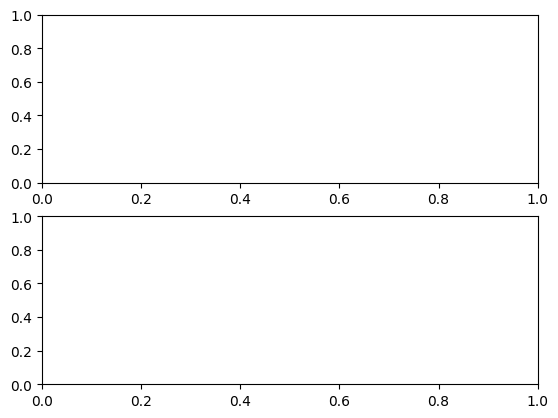

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1)
#ax[0].plot(range(15), test_fit.history['val_accuracy'], label="Training Accuracy")
test_fit.history

In [ ]:
mean_squared_error()